In [1]:
#Shor's Algorithm Qiskit: https://learn.qiskit.org/course/ch-algorithms/shors-algorithm
#controlled multiplcation circuits: https://arxiv.org/abs/quant-ph/0205095

In [3]:
# Ignoring warnings
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [14]:
# Note: This can be any hub/group/project that has access to the required device and the Qiskit runtime.
hub = "ibm-q"
group = "open"
project = "main"
backend_name = "ibm_brisbane"
hgp = f"{hub}/{group}/{project}"

In [15]:
#fetch api_key
with open("api_key.txt","r") as f:
    api_key = f.read()

In [16]:
import qiskit
from qiskit_ibm_provider import IBMProvider

# Save token if necessary
IBMProvider.save_account(overwrite=True,token=api_key)

# Get our backend
provider = IBMProvider()
available_backends = provider.backends()
backend = provider.get_backend(backend_name, instance=hgp)
print(f"Using backend {backend.name}")

Using backend ibm_brisbane


In [17]:
import matplotlib.pyplot as plt
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram
from math import gcd
from numpy.random import randint
import pandas as pd
from fractions import Fraction
print("Imports Successful")

Imports Successful


In [8]:
def c_amod15(a, power):
    """Controlled multiplication by a mod 15"""
    if a not in [2,4,7,8,11,13]:
        raise ValueError("'a' must be 2,4,7,8,11 or 13")
    U = QuantumCircuit(4)
    for _iteration in range(power):
        if a in [2,13]:
            U.swap(2,3)
            U.swap(1,2)
            U.swap(0,1)
        if a in [7,8]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
        if a in [4, 11]:
            U.swap(1,3)
            U.swap(0,2)
        if a in [7,11,13]:
            for q in range(4):
                U.x(q)
    U = U.to_gate()
    U.name = f"{a}^{power} mod 15"
    c_U = U.control()
    return c_U

In [9]:
# Specify variables
N_COUNT = 8  # number of counting qubits
a = 7

In [10]:
def qft_dagger(n):
    """n-qubit QFTdagger the first n qubits in circ"""
    qc = QuantumCircuit(n)
    # Don't forget the Swaps!
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi/float(2**(j-m)), m, j)
        qc.h(j)
    qc.name = "QFT†"
    return qc

In [11]:
# Create QuantumCircuit with N_COUNT counting qubits
# plus 4 qubits for U to act on
qc = QuantumCircuit(N_COUNT + 4, N_COUNT)

# Initialize counting qubits
# in state |+>
for q in range(N_COUNT):
    qc.h(q)

# And auxiliary register in state |1>
qc.x(N_COUNT)

# Do controlled-U operations
for q in range(N_COUNT):
    qc.append(c_amod15(a, 2**q),
             [q] + [i+N_COUNT for i in range(4)])

# Do inverse-QFT
qc.append(qft_dagger(N_COUNT), range(N_COUNT))

# Measure circuit
qc.measure(range(N_COUNT), range(N_COUNT))
qc.draw(fold=-1)  # -1 means 'do not fold'

┌───┐                                                                                                                             ┌───────┐┌─┐                     
 q_0: ┤ H ├───────■─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤0      ├┤M├─────────────────────
      ├───┤       │                                                                                                                     │       │└╥┘┌─┐                  
 q_1: ┤ H ├───────┼──────────────■──────────────────────────────────────────────────────────────────────────────────────────────────────┤1      ├─╫─┤M├──────────────────
      ├───┤       │              │                                                                                                      │       │ ║ └╥┘┌─┐               
 q_2: ┤ H ├───────┼──────────────┼──────────────■───────────────────────────────────────────────────────────────────────────────────────┤2      ├─╫──╫─┤M├───────────────
      ├───┤       │              │              │                                                                                       │       │ ║  ║ └╥┘┌─┐            
 q_3: ┤ H ├───────┼──────────────┼──────────────┼──────────────■────────────────────────────────────────────────────────────────────────┤3      ├─╫──╫──╫─┤M├────────────
      ├───┤       │              │              │              │                                                                        │  QFT† │ ║  ║  ║ └╥┘┌─┐         
 q_4: ┤ H ├───────┼──────────────┼──────────────┼──────────────┼──────────────■─────────────────────────────────────────────────────────┤4      ├─╫──╫──╫──╫─┤M├─────────
      ├───┤       │              │              │              │              │                                                         │       │ ║  ║  ║  ║ └╥┘┌─┐      
 q_5: ┤ H ├───────┼──────────────┼──────────────┼──────────────┼──────────────┼───────────────■─────────────────────────────────────────┤5      ├─╫──╫──╫──╫──╫─┤M├──────
      ├───┤       │              │              │              │              │               │                                         │       │ ║  ║  ║  ║  ║ └╥┘┌─┐   
 q_6: ┤ H ├───────┼──────────────┼──────────────┼──────────────┼──────────────┼───────────────┼───────────────■─────────────────────────┤6      ├─╫──╫──╫──╫──╫──╫─┤M├───
      ├───┤       │              │              │              │              │               │               │                         │       │ ║  ║  ║  ║  ║  ║ └╥┘┌─┐
 q_7: ┤ H ├───────┼──────────────┼──────────────┼──────────────┼──────────────┼───────────────┼───────────────┼────────────────■────────┤7      ├─╫──╫──╫──╫──╫──╫──╫─┤M├
      ├───┤┌──────┴──────┐┌──────┴──────┐┌──────┴──────┐┌──────┴──────┐┌──────┴───────┐┌──────┴───────┐┌──────┴───────┐┌───────┴───────┐└───────┘ ║  ║  ║  ║  ║  ║  ║ └╥┘
 q_8: ┤ X ├┤0            ├┤0            ├┤0            ├┤0            ├┤0             ├┤0             ├┤0             ├┤0              ├──────────╫──╫──╫──╫──╫──╫──╫──╫─
      └───┘│             ││             ││             ││             ││              ││              ││              ││               │          ║  ║  ║  ║  ║  ║  ║  ║ 
 q_9: ─────┤1            ├┤1            ├┤1            ├┤1            ├┤1             ├┤1             ├┤1             ├┤1              ├──────────╫──╫──╫──╫──╫──╫──╫──╫─
           │  7^1 mod 15 ││  7^2 mod 15 ││  7^4 mod 15 ││  7^8 mod 15 ││  7^16 mod 15 ││  7^32 mod 15 ││  7^64 mod 15 ││  7^128 mod 15 │          ║  ║  ║  ║  ║  ║  ║  ║ 
q_10: ─────┤2            ├┤2            ├┤2            ├┤2            ├┤2             ├┤2             ├┤2             ├┤2              ├──────────╫──╫──╫──╫──╫──╫──╫──╫─
           │             ││             ││             ││             ││              ││              ││              ││               │          ║  ║  ║  ║  ║  ║  ║  ║ 
q_11: ─────┤3            ├┤3            ├┤3            ├┤3            ├┤3             ├┤3       

In [20]:
from qiskit_ibm_runtime import SamplerV2 as Sampler, QiskitRuntimeService
 
# Define the service.  This allows you to access IBM QPUs.
service = QiskitRuntimeService()
 
# Get a backend, real or simulator
backend = service.least_busy(operational=True, simulator=False)
#backend = Aer.get_backend('aer_simulator')
 
# Define Sampler
sampler = Sampler(mode=backend)

# transpile the circuit
t_qc = transpile(qc, backend)

# Run calculation
job = sampler.run([t_qc])
 
result = job.result()

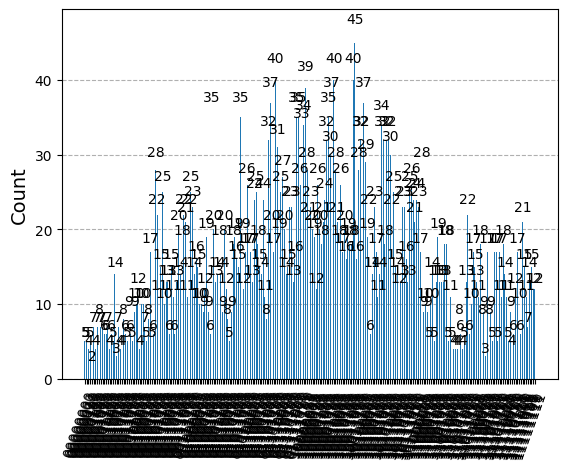

In [21]:
# Get the counts
counts = result[0].data.c.get_counts()
plot_histogram(counts)

In [22]:
rows, measured_phases = [], []
for output, count in counts.items():  # Now considering actual counts
    decimal = int(output, 2)  # Convert (base 2) string to decimal
    phase = decimal / (2**N_COUNT)  # Find corresponding eigenvalue
    measured_phases.extend([phase] * count)  # Store phase weighted by count
    rows.append([f"{output}(bin) = {decimal:>3}(dec)",
                 f"{decimal}/{2**N_COUNT} = {phase:.2f}",
                 count])  # Add count information

# Print the table with count info
headers = ["Register Output", "Phase", "Counts"]
df = pd.DataFrame(rows, columns=headers)
print(df)

# Now, convert phases to fractions
rows = []
for phase in measured_phases:
    frac = Fraction(phase).limit_denominator(15)
    rows.append([phase,
                 f"{frac.numerator}/{frac.denominator}",
                 frac.denominator])

# Print fraction table
headers = ["Phase", "Fraction", "Guess for r"]
df = pd.DataFrame(rows, columns=headers)
print(df)


              Register Output           Phase  Counts
0    10101110(bin) = 174(dec)  174/256 = 0.68      22
1    01110011(bin) = 115(dec)  115/256 = 0.45      15
2    01101101(bin) = 109(dec)  109/256 = 0.43      31
3    10111001(bin) = 185(dec)  185/256 = 0.72      26
4    01111001(bin) = 121(dec)  121/256 = 0.47      35
..                        ...             ...     ...
251  00001110(bin) =  14(dec)   14/256 = 0.05       4
252  11010110(bin) = 214(dec)  214/256 = 0.84       4
253  00000100(bin) =   4(dec)    4/256 = 0.02       2
254  11100011(bin) = 227(dec)  227/256 = 0.89       3
255  00000010(bin) =   2(dec)    2/256 = 0.01       4

[256 rows x 3 columns]
         Phase Fraction  Guess for r
0     0.679688     9/13           13
1     0.679688     9/13           13
2     0.679688     9/13           13
3     0.679688     9/13           13
4     0.679688     9/13           13
...        ...      ...          ...
4091  0.886719      8/9            9
4092  0.007812      0/1         

In [26]:
#find a suitable value a such that a and N are coprime
from math import gcd # greatest common divisor
N = 15
np.random.seed(1) # This is to make sure we get reproduceable results
a = randint(2, N)
print(a)
gcd(a, N)

7


1

In [24]:
#quantum phase estimation for N=15 with manual U gates
def qpe_amod15(a):
    """Performs quantum phase estimation on the operation a*r mod 15.
    Args:
        a (int): This is 'a' in a*r mod 15
    Returns:
        float: Estimate of the phase
    """
    N_COUNT = 8
    qc = QuantumCircuit(4+N_COUNT, N_COUNT)
    for q in range(N_COUNT):
        qc.h(q)     # Initialize counting qubits in state |+>
    qc.x(3+N_COUNT) # And auxiliary register in state |1>
    for q in range(N_COUNT): # Do controlled-U operations
        qc.append(c_amod15(a, 2**q),
                 [q] + [i+N_COUNT for i in range(4)])
    qc.append(qft_dagger(N_COUNT), range(N_COUNT)) # Do inverse-QFT
    qc.measure(range(N_COUNT), range(N_COUNT))
    # Simulate Results
    t_qc = transpile(qc, backend)
    job = sampler.run([t_qc])
    result = job.result()
    counts = result[0].data.c.get_counts()
    max_index = max(counts)
    max_count = counts[max_index]
    print("Register Reading: " + str(max_count))
    phase = max_count/(2**N_COUNT)
    print(f"Corresponding Phase: {phase}")
    return phase

In [27]:
#phase = qpe_amod15(a) # Phase = s/r
Fraction(phase).limit_denominator(15)
r = frac.denominator
guesses = [gcd(a**(r//2)-1, N), gcd(a**(r//2)+1, N)]
print("Period: ", r)
print("Guess for factors: ",guesses)

Period:  1
Guess for factors:  [15, 1]


In [46]:
a = 7
FACTOR_FOUND = False
ATTEMPT = 0
while not FACTOR_FOUND:
    ATTEMPT += 1
    print(f"\nATTEMPT {ATTEMPT}:")
    phase = qpe_amod15(a) # Phase = s/r
    frac = Fraction(phase).limit_denominator(N)
    r = frac.denominator
    print(f"Result: r = {r}")
    if phase != 0:
        # Guesses for factors are gcd(x^{r/2} ±1 , 15)
        guesses = [gcd(a**(r//2)-1, N), gcd(a**(r//2)+1, N)]
        print(f"Guessed Factors: {guesses[0]} and {guesses[1]}")
        for guess in guesses:
            if guess not in [1,N] and (N % guess) == 0:
                # Guess is a factor!
                print("*** Non-trivial factor found: {guess} ***")
                FACTOR_FOUND = True


ATTEMPT 1:
Register Reading: 257
Corresponding Phase: 1.00390625
Result: r = 1
Guessed Factors: 15 and 1

ATTEMPT 2:
Register Reading: 256
Corresponding Phase: 1.0
Result: r = 1
Guessed Factors: 15 and 1

ATTEMPT 3:
Register Reading: 262
Corresponding Phase: 1.0234375
Result: r = 1
Guessed Factors: 15 and 1

ATTEMPT 4:
Register Reading: 252
Corresponding Phase: 0.984375
Result: r = 1
Guessed Factors: 15 and 1

ATTEMPT 5:
Register Reading: 260
Corresponding Phase: 1.015625
Result: r = 1
Guessed Factors: 15 and 1

ATTEMPT 6:
Register Reading: 257
Corresponding Phase: 1.00390625
Result: r = 1
Guessed Factors: 15 and 1

ATTEMPT 7:
Register Reading: 260
Corresponding Phase: 1.015625
Result: r = 1
Guessed Factors: 15 and 1

ATTEMPT 8:
Register Reading: 273
Corresponding Phase: 1.06640625
Result: r = 15
Guessed Factors: 3 and 1
*** Non-trivial factor found: {guess} ***
